# ECG Anomaly Detection

## Introduction

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
# Load the data

df = pd.read_csv('data/ecg.csv', header=None)
raw_data = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
raw_data

array([[-0.11252183, -2.8272038 , -3.7738969 , ...,  0.92528624,
         0.19313742,  1.        ],
       [-1.1008778 , -3.9968398 , -4.2858426 , ...,  1.1196209 ,
        -1.4362499 ,  1.        ],
       [-0.56708802, -2.5934502 , -3.8742297 , ...,  0.90422673,
        -0.42179659,  1.        ],
       ...,
       [-1.1229693 , -2.2529248 , -2.8676281 , ..., -2.0083694 ,
        -1.8083338 ,  0.        ],
       [-0.54770461, -1.8895451 , -2.8397786 , ...,  1.1504486 ,
         0.80493225,  0.        ],
       [-1.3517791 , -2.2090058 , -2.5202247 , ..., -1.577823  ,
        -0.68453092,  0.        ]])

In [4]:
df.shape

(4998, 141)

In [5]:
# train test split
y = raw_data[:,-1]
X = raw_data[:,0:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
min_val = tf.reduce_min(X_train)
max_val = tf.reduce_max(y_train)

X_train = (X_train - min_val) / (max_val - min_val)
X_test = (X_test - min_val) / (max_val - min_val)

X_train = tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)

In [7]:
# Seperate normal from abnormal rhythms
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

norm_X_train = X_train[y_train]
norm_X_test = X_test[y_test]

abnorm_X_train = X_train[~y_train]
abnorm_X_test = X_test[~y_test]

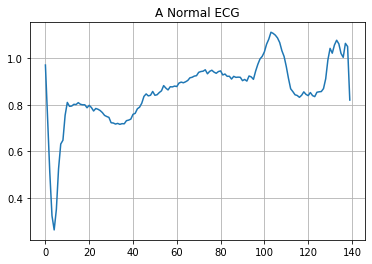

In [8]:
# plot normal rhythm
plt.grid()
plt.plot(np.arange(140), norm_X_train[0])
plt.title("A Normal ECG")
plt.show()

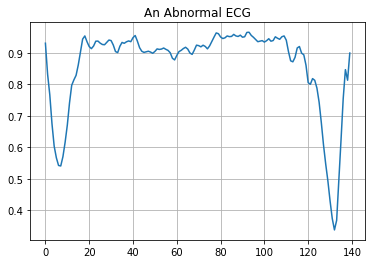

In [9]:
# plot abnormal rhythm
plt.grid()
plt.plot(np.arange(140), abnorm_X_train[0])
plt.title("An Abnormal ECG")
plt.show()

In [10]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss='mae')

In [11]:
history = autoencoder.fit(norm_X_train, norm_X_train, 
          epochs=20, 
          batch_size=512,
          validation_data=(X_test, X_test),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 0s 20ms/step - loss: 0.3699 - val_loss: 0.3636
Epoch 2/20
5/5 [==============================] - 0s 4ms/step - loss: 0.3589 - val_loss: 0.3459
Epoch 3/20
5/5 [==============================] - 0s 4ms/step - loss: 0.3357 - val_loss: 0.3155
Epoch 4/20
5/5 [==============================] - 0s 3ms/step - loss: 0.2989 - val_loss: 0.2701
Epoch 5/20
5/5 [==============================] - 0s 3ms/step - loss: 0.2461 - val_loss: 0.2111
Epoch 6/20
5/5 [==============================] - 0s 3ms/step - loss: 0.1855 - val_loss: 0.1552
Epoch 7/20
5/5 [==============================] - 0s 3ms/step - loss: 0.1381 - val_loss: 0.1207
Epoch 8/20
5/5 [==============================] - 0s 3ms/step - loss: 0.1108 - val_loss: 0.1022
Epoch 9/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0948 - val_loss: 0.0896
Epoch 10/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0810 - val_loss: 0.0780
Epoch 11/20
5/5 [=====================

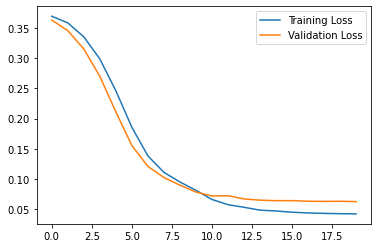

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend();

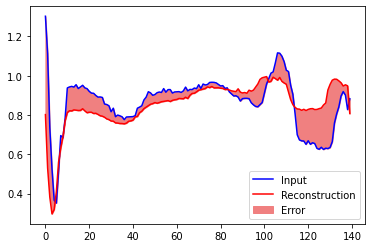

In [13]:
encoded_imgs = autoencoder.encoder(norm_X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(norm_X_test[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], norm_X_test[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()